In [52]:
import os
import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

from tqdm import tqdm

from model.cfm_model import *
from CFM.models.unet import UNetModel
from CFM.models.MLP import MLP

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [62]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "mps")
batch_size = 128
n_epochs = 3

trainset = datasets.MNIST(
    "MNISTdata",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [63]:
sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
#model = MLP(dim=28*28).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [64]:
FM = ConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver='dopri5', sensitivity='adjoint', atol=1e-4, rtol=1e-4)

In [61]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

0it [00:00, ?it/s]


TypeError: MLP.forward() takes 2 positional arguments but 3 were given

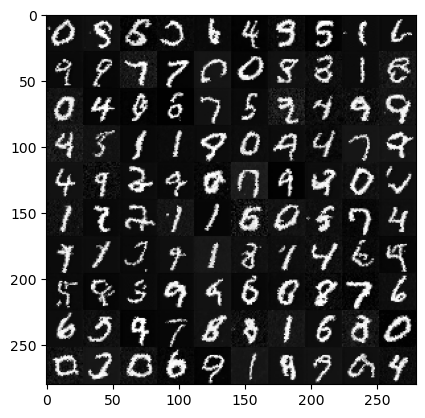

In [11]:
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 1, 28, 28).to(device),
        t_span=torch.linspace(0, 1, 2).to(device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

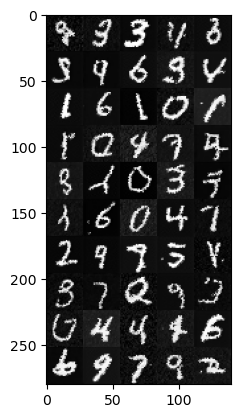

In [17]:
import numpy as np
td = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
with torch.no_grad():
    prior = torch.randn(50, 1, 28, 28).to(device)
    for i in td:
        pred = node.transition(
            prior, 
            t_span=torch.linspace(0, 1, 10).to(device)
        )
        prior = pred[td+1]
        
    pred = node.trajectory(
        torch.randn(50, 1, 28, 28).to(device),
        t_span=torch.linspace(0, 1, 20).to(device)
    )

grid2 = make_grid(
    pred[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=5
)
img = ToPILImage()(grid2)
plt.imshow(img)
    

Step 0/5...


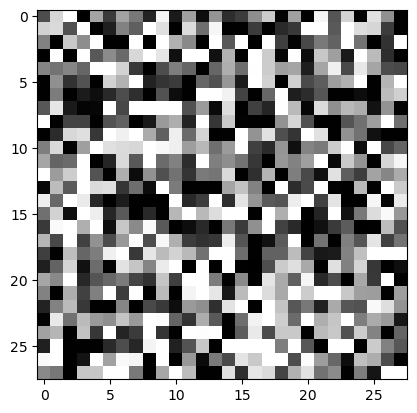

Step 1/5...


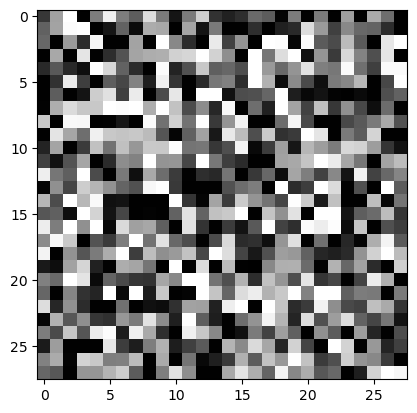

Step 2/5...


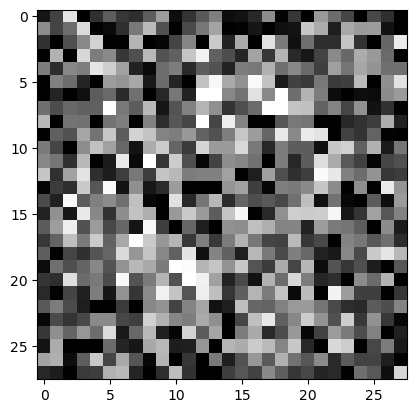

Step 3/5...


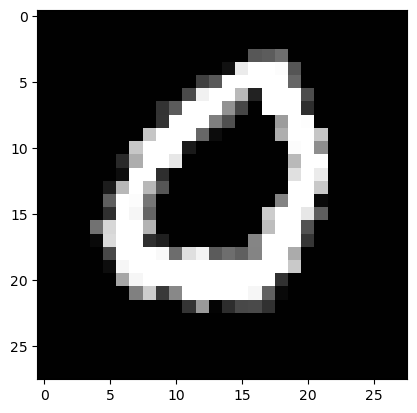

Step 4/5...


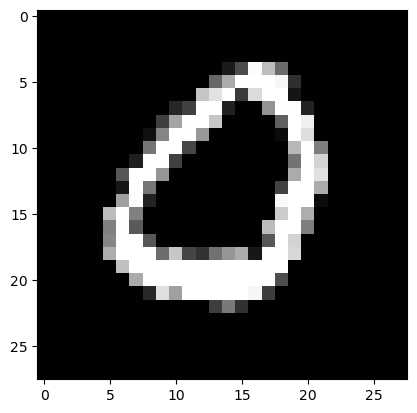

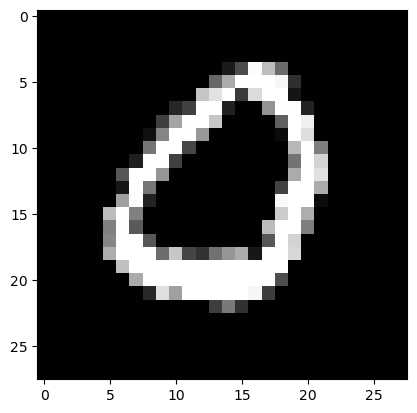

In [50]:
from IPython import display
def draw_image(traj):
    grid2 = make_grid(
        traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=2
    )
    img = ToPILImage()(grid2)
    plt.imshow(img)
    display.display(plt.gcf())
    

td = np.arange(5)
with torch.no_grad():
    prior = torch.randn(1, 1, 28, 28).to(device)
    for i in td:
        print(f"Step {i}/{len(td)}...")
        pred = node.trajectory(
            prior, 
            t_span=torch.linspace(0, 1, len(td)).to(device)
        )
        
        # print(f"Shape of the prior: {prior.shape}\nShape of the prediction: {pred.shape}")
        prior = pred[i, :100]
        # print(f"Shape of the new prior: {prior.shape}")
        draw_image(prior)
    pred = prior    